# Multiset Ansatz: Exciton Dynamics in the 1D Holstein Model

In this quickstart guide, we apply pyTTN to evaluate exciton dynamics in the 1D Holstein model in the single excitation subspace using a Multiset TTN ansatz.  The Multiset approach represents the wavefunction as
$$ \ket{\Psi} = \sum_{\alpha} \ket{\alpha} \ket{\Psi^{\alpha}} $$

where $\ket{\alpha}$ is a set of system states (here the singly occupied electronic states) and each $\ket{\Psi^{\alpha}}$ is a separate TTN associated with the given system state.  In this example, we apply this ansatz to consider the dynamics of the 1D Holstein model with Hamiltonian

$$ \hat{H} = \omega_0 \sum_{i=1}^N \hat{b}_i^\dagger \hat{b}_i + g\omega_0 \sum_{i=1}^N (\hat{b}_i^\dagger + \hat{b}_i) \ket{i}\bra{i}  + J \sum_{<i,j>} \ket{i}\bra{j} $$ 

where the last summation is limited to nearest neighbour sites, and here we will consider periodic boundary conditions. Here we will consider a set of models that have previously been considered in [B. Kloss, D. Reichman, R. Tempelaar, Phys. Rev. Lett. 123, 126601 (2019)](https://doi.org/10.1103/PhysRevLett.123.126601).  

### Contents


1. [Importing the Package](#importing-the-package)

2. [Setting up the System and Hamiltonian](#setting-up-the-system-and-hamiltonian)

3. [Preparing the Initial Wavefunction](#preparing-the-initial-wavefunction)

4. [Preparing the sop_operator Representation of the Hamiltonian](#preparing-the-sop_operator-hamiltonian)

5. [Running the Dynamics](#running-the-dynamics)

6. [Putting it all Together](#putting-it-all-together)

7. [Results](#results)

### Importing the Package

We start by importing the required modules for this example

In [7]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np

import pyttn
from pyttn.utils import visualise_tree

### Setting up the System and Hamiltonian

We now by defining a function that by sets up the `system_modes` object used in handling tensor networks for this system.  Due to the use of the multiset ansatz, we only need to include information about the vibrational modes in the definition of this system.  As such we can obtain the system information object using the following function that takes the number of sites in the model, as well as the local Hilbert space dimension for each bosonic mode. 

In [8]:
def setup_system(N, nhilb):
    # Initialise system information variable as a set of N modes
    sysinf = pyttn.system_modes(N)

    # Specify that each mode is a two level system
    for i in range(N):
        sysinf[i] = pyttn.boson_mode(nhilb)

    return sysinf

We now define a function for setting up the system Hamiltonian.  Here, as we are using a multiset ansatz, we need to make use of the `multiset_SOP` class.  This class extends the `SOP` functionality to the multiset case, allowing for the specification of a matrix of `SOP` objects that act on the multiset wavefunction.  For more details on the generation of `SOP` operators see the [tutorial on operator generation](file/../operator_generation.ipynb).

In [9]:
def Hamiltonian(g, w0, J, N):
    #set up the system Hamiltonian.  Here we need a multiset_SOP 
    #with N set variables and N modes for each set variable
    H = pyttn.multiset_SOP(N, N)
    print("                   ", end='\r', flush=True)
    #add on the electronic coupling terms
    for i in range(N):
        j = (i+1)%N     #enforce the periodic boundary conditions
        H[i, j] += J
        H[j, i] += J

    #add on the purely bosonic terms
    for i in range(N):
        for j in range(N):
            H[i, i] += w0*pyttn.sOP("n", j)

    #now add on the system bath coupling terms
    for i in range(N):
        H[i, i] += g*(pyttn.sOP("adag", i)+pyttn.sOP("a", i))

    return H

### Preparing the Initial Wavefunction

We will now define a function for preparing the initial wavefunction. This requires a two-step process, first we define the tree topology to use for this calculation through the use of the `ntree` class (which for this example we choose to be an MPS), following which we construct the `ms_ttn` object that actually represents the wavefunction.  For more details one the construct of tree topologies see the [tutorial on tree topologies](file/../tree_topologies.ipynb). In this example, we define a function that takes the `system_modes` information as well as bond dimension and locally optimised boson basis size to construct the initial wavefunction.  Here we consider an initial state in which central electronic site is occupied and all vibrational modes are in the vacuum state.


In [10]:
def psi0(sys, chi, nopt):
    N = sys.nprimitive_modes()

    #build the MPS tree topology
    class chi_step:
        def __init__(self, chimax, chimin, N, degree = 2):
            self.chimin = chimin
            if N%degree == 0:
                self.Nl = int(int(np.log(N)/np.log(degree))+1)
            else:
                self.Nl = int(int(np.log(N)/np.log(degree))+2)
    
            self.nx = int((chimax-chimin)//self.Nl)
         
        def __call__(self, l):
            ret=int((self.Nl-l)*self.nx+self.chimin)
            return ret
    topo = pyttn.ntreeBuilder.mlmctdh_tree(sys.mode_dimensions(), 2, chi_step(chi, nopt, N))
    #construct the multiset tensor network object
    psi = pyttn.ms_ttn(N, topo)

    #set the initial state
    state = [[0 for i in range(N)] for j in range(N)]
    coeff = np.zeros(N, dtype=np.float64)
    coeff[N//2] = 1
    psi.set_state(coeff, state)
    return psi

### Preparing the `sop_operator` Hamiltonian

Now before we are ready to set up and perform the TDVP loop, we first need to convert the Hamiltonian into a form that can be used to efficiently within the TDVP algorithms.  Here we define a function that constructs a multiset variant of the hierarchical sum-of-product operator, which we can construct from a `multiset_SOP`, `ms_ttn` and `system_modes` information.

In [11]:
def hamiltonian_operator(H, A, sysinf):
    return pyttn.ms_sop_operator(H, A, sysinf)

### Running the Dynamics

Now we define a function that will perform the dynamics and return all electronic site populations.

In [12]:
#define a function for running multiple sub steps to perform the first step
def run_initial_step(A, h, sweep, dt, nstep=10):
    tp = 0
    ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), nstep)
    for i in range(nstep):
        print(i, end='\r', flush=True)
        dti = ts[i]-tp
        sweep.dt = dti
        sweep.step(A, h)
        tp = ts[i]
    return A, h, sweep

def simulate_dynamics(h, A):
    N = A.nmodes()

    #set up the time evolution parameters
    dt = 0.05
    tmax = 2*np.pi*3
    nsteps = int(tmax/dt)+1

    #setup the matrix element calculation object
    mel = pyttn.matrix_element(A)

    #set up the TDVP sweeping object to 
    sweep = pyttn.tdvp(A, h, krylov_dim = 8)
    sweep.expmv_tol=1e-10
    sweep.dt = dt
    sweep.coefficient = -1.0j

    #setup buffers for storing the results
    site_pops = np.zeros((nsteps+1, N))

    #compute the site populations which is just the $\braket{\Psi^{i}}{\Psi^{i}}$
    for j in range(N):
        site_pops[0, j] = mel(A.slice(j))

    #perform a set of steps with a logarithmic timestep discretisation
    A, h, sweep = run_initial_step(A, h, sweep, dt)
    
    for j in range(N):
        site_pops[1, j] = mel(A.slice(j))

    sweep.dt = dt
    
    timepoints = (np.arange(nsteps+1)*dt)
    
    #perform the remaining dynamics steps
    for i in range(1, nsteps):
        sweep.step(A, h)
            
        for j in range(N):
            site_pops[i+1, j] = mel(A.slice(j))

        print("step: %d of %d"%(i+1, nsteps), end='                   \r', flush=True)

    print("                                 ", end="\r")
    t = np.arange(nsteps+1)*dt

    return t, site_pops

### Putting it all Together

Now putting this all together we finally define a function for setting up and running the entire dynamics:

In [13]:
def Holstein_sim(g, w0, J, N, Nhilb, chi, nopt):
    #build the system
    sysinf = setup_system(N, Nhilb)
    print("system setup")

    #setup the Hamiltonian
    H = Hamiltonian(g, w0, J, N)
    print("Hamiltonian setup")

    #prepare the wavefunction
    A = psi0(sysinf, chi, nopt)
    print("wavefunction prepared")

    #set up the Hamiltonian operator
    h = hamiltonian_operator(H, A, sysinf)
    print("sop operator constructed")

    #run the dynamics and return the results
    return simulate_dynamics(h, A)

Now that we have defined all of these functions we can simulate the parameter regimes we aim to consider.  In this example we consider the dynamics of three different regimes:

| Simulations | $g$ | $\omega_0$ | $J$ | $N$ | $N_{hilb}$ | $\chi$ | 
| --- | --- | --- | --- | --- | --- | --- |
| a)          | 0.5 | 1 | 1 |  75 | 8 | 8 |
| b)          | 1.5 | 1 | 1 |  31 | 16 | 12 |
| c)          | 2.5 | 1 | 1 |  25 | 64 | 16 |

In [14]:
t, pops_a = Holstein_sim(0.5, 1, 1, 75, 8, 8, 4)
t, pops_b = Holstein_sim(1.5, 1, 1, 31, 16, 12, 6)
t, pops_c = Holstein_sim(2.5, 1, 1, 25, 64, 16, 8)

#and save outputs to file
import h5py
h5 = h5py.File("holstein_1d.h5", "w")
h5.create_dataset('t', data=t)
h5.create_dataset('pops_a', data=pops_a)
h5.create_dataset('pops_b', data=pops_b)
h5.create_dataset('pops_c', data=pops_c)

h5.close()

system setup
Hamiltonian setup  
wavefunction prepared
sop operator constructed
system setup                       
Hamiltonian setup  
wavefunction prepared
sop operator constructed
system setup                                                                               
Hamiltonian setup  
wavefunction prepared
sop operator constructed


And now that we have the results we plot them:

0
0
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


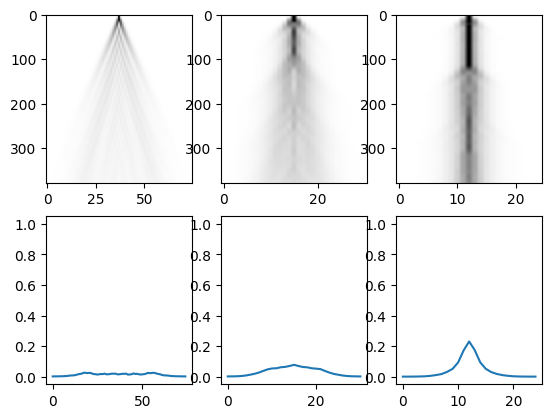

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import h5py
import numpy as np
from matplotlib import rc
rc('animation', html='html5')

h5 = h5py.File("holstein_1d.h5", "r")
t = np.array(h5.get('t'))
pops_a = np.array(h5.get('pops_a'))
pops_b = np.array(h5.get('pops_b'))
pops_c = np.array(h5.get('pops_c'))
h5.close()

for i in plt.get_fignums():
    plt.close(i)

fig, ax = plt.subplots(nrows=2, ncols=3)

l1, = ax[1, 0].plot(pops_a[0, :])
l2, = ax[1, 1].plot(pops_b[0, :])
l3, = ax[1, 2].plot(pops_c[0, :])

ax[0, 0].imshow(pops_a, cmap = 'binary', aspect='auto', vmax=0.5)
ax[0, 1].imshow(pops_b, cmap = 'binary', aspect='auto', vmax=0.5)
ax[0, 2].imshow(pops_c, cmap = 'binary', aspect='auto', vmax=0.5)
print(len(t))
def animate(i):
    l1.set_ydata(pops_a[i, :])
    l2.set_ydata(pops_b[i, :])
    l3.set_ydata(pops_c[i, :])
    return l1, l2, l3,

anim = animation.FuncAnimation(fig, animate, interval=20, blit=True, frames = len(t))

